In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord

from nsb2.atmosphere import SingleScatteringAtmosphere
from nsb2.core.lightpath import DirectPath, ScatteredPath
from nsb2.core.pipeline import Pipeline
from nsb2.core.solver import (
    LUTDirectSolver,
    LUTScatteredSolver,
)
from nsb2.emitter import airglow, moon, stars, zodiacal
from nsb2.instrument import CTAO

# Creating Pipeline:

In [2]:
# Sources:
glow = airglow.from_eso_skycalc(87*u.km, 100)
zodi = zodiacal.from_leinert1998()

h_bright = stars.from_gaia_suppl_catalog()
h_bright.build_balltree()

u_mag15 = stars.from_gaia_dr3_catalog()
u_mag15.build_balltree()

u_mag15_map = u_mag15.to_map(2**6)
o_mag15 = stars.from_gaia_dr3_map()

noll13 = moon.from_noll2013()

In [3]:
# Atmosphere
def X(Z):
    return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))

def t_r(lam, height):
    return 0.00879*(lam.to(u.micron).value)**-4.09 * np.exp(-height.to(u.km).value/8)

def t_m(lam, height, aero):
    return aero[0]*(lam.to(u.nm).value/380)**(-aero[1]) * np.exp(-height.to(u.km).value/1.54)

def t_a(lam):
    return np.zeros(lam.shape)

atmo = SingleScatteringAtmosphere(X,
                                  lambda x: t_r(x, 8*u.km),
                                  lambda x: t_m(x, 1.8*u.km, [0.5, 1]),
                                  t_a,
                                  0.8)

In [4]:
# Instrument:
lst1 = CTAO.LST1North()

## Building and compiling model:

In [5]:
model_diff = Pipeline(lst1, atmo, [glow, zodi, noll13],
                      paths=[DirectPath(), ScatteredPath()])

model_star = Pipeline(lst1, atmo, [h_bright, u_mag15, o_mag15],
                      paths=[DirectPath(solver=LUTDirectSolver())])

model_star_scatter = Pipeline(lst1, atmo, [h_bright, u_mag15_map, o_mag15],
                              paths=[ScatteredPath(solver=LUTScatteredSolver())])

# Compose and compile
model = model_star + model_star_scatter + model_diff
model.compile(extinction_z_bins=90, scattering_z_bins=10, scattering_theta_bins=10)

0

## Predicting an observation:

In [6]:
import astropy
from astropy.coordinates import AltAz, SkyOffsetFrame

rotation = 0*u.deg
location = astropy.coordinates.EarthLocation.from_geodetic(17.89, 28.76, 2.2*u.km)
obstime  = astropy.time.Time('2021-01-18T23:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('crab_nebula')
base = AltAz(obstime=obstime, location=location,
             pressure=1000*u.hPa, relative_humidity=0.3, temperature=20*u.deg_C)

observation = SkyOffsetFrame(origin=target.transform_to(base), rotation=rotation)

In [7]:
%%time
pred = model.predict(observation)

CPU times: user 4.91 s, sys: 1.68 s, total: 6.59 s
Wall time: 6.63 s


# Visualizing the data:

In [8]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

cam = CameraGeometry.from_name('LSTCam')
def ctapipe_disp(cam, rates, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = rates
    display.add_colorbar(label=label)
    return display

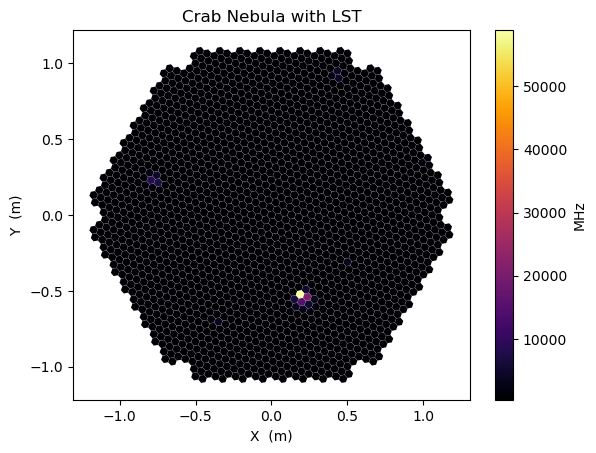

In [9]:
fig, ax = plt.subplots()
p_all = [p.rates.to(u.MHz)[:,1] for p in pred]
disp = ctapipe_disp(cam, np.array(p_all).sum(axis=0), ax, label='MHz', show_frame=False, title='Crab Nebula with LST')

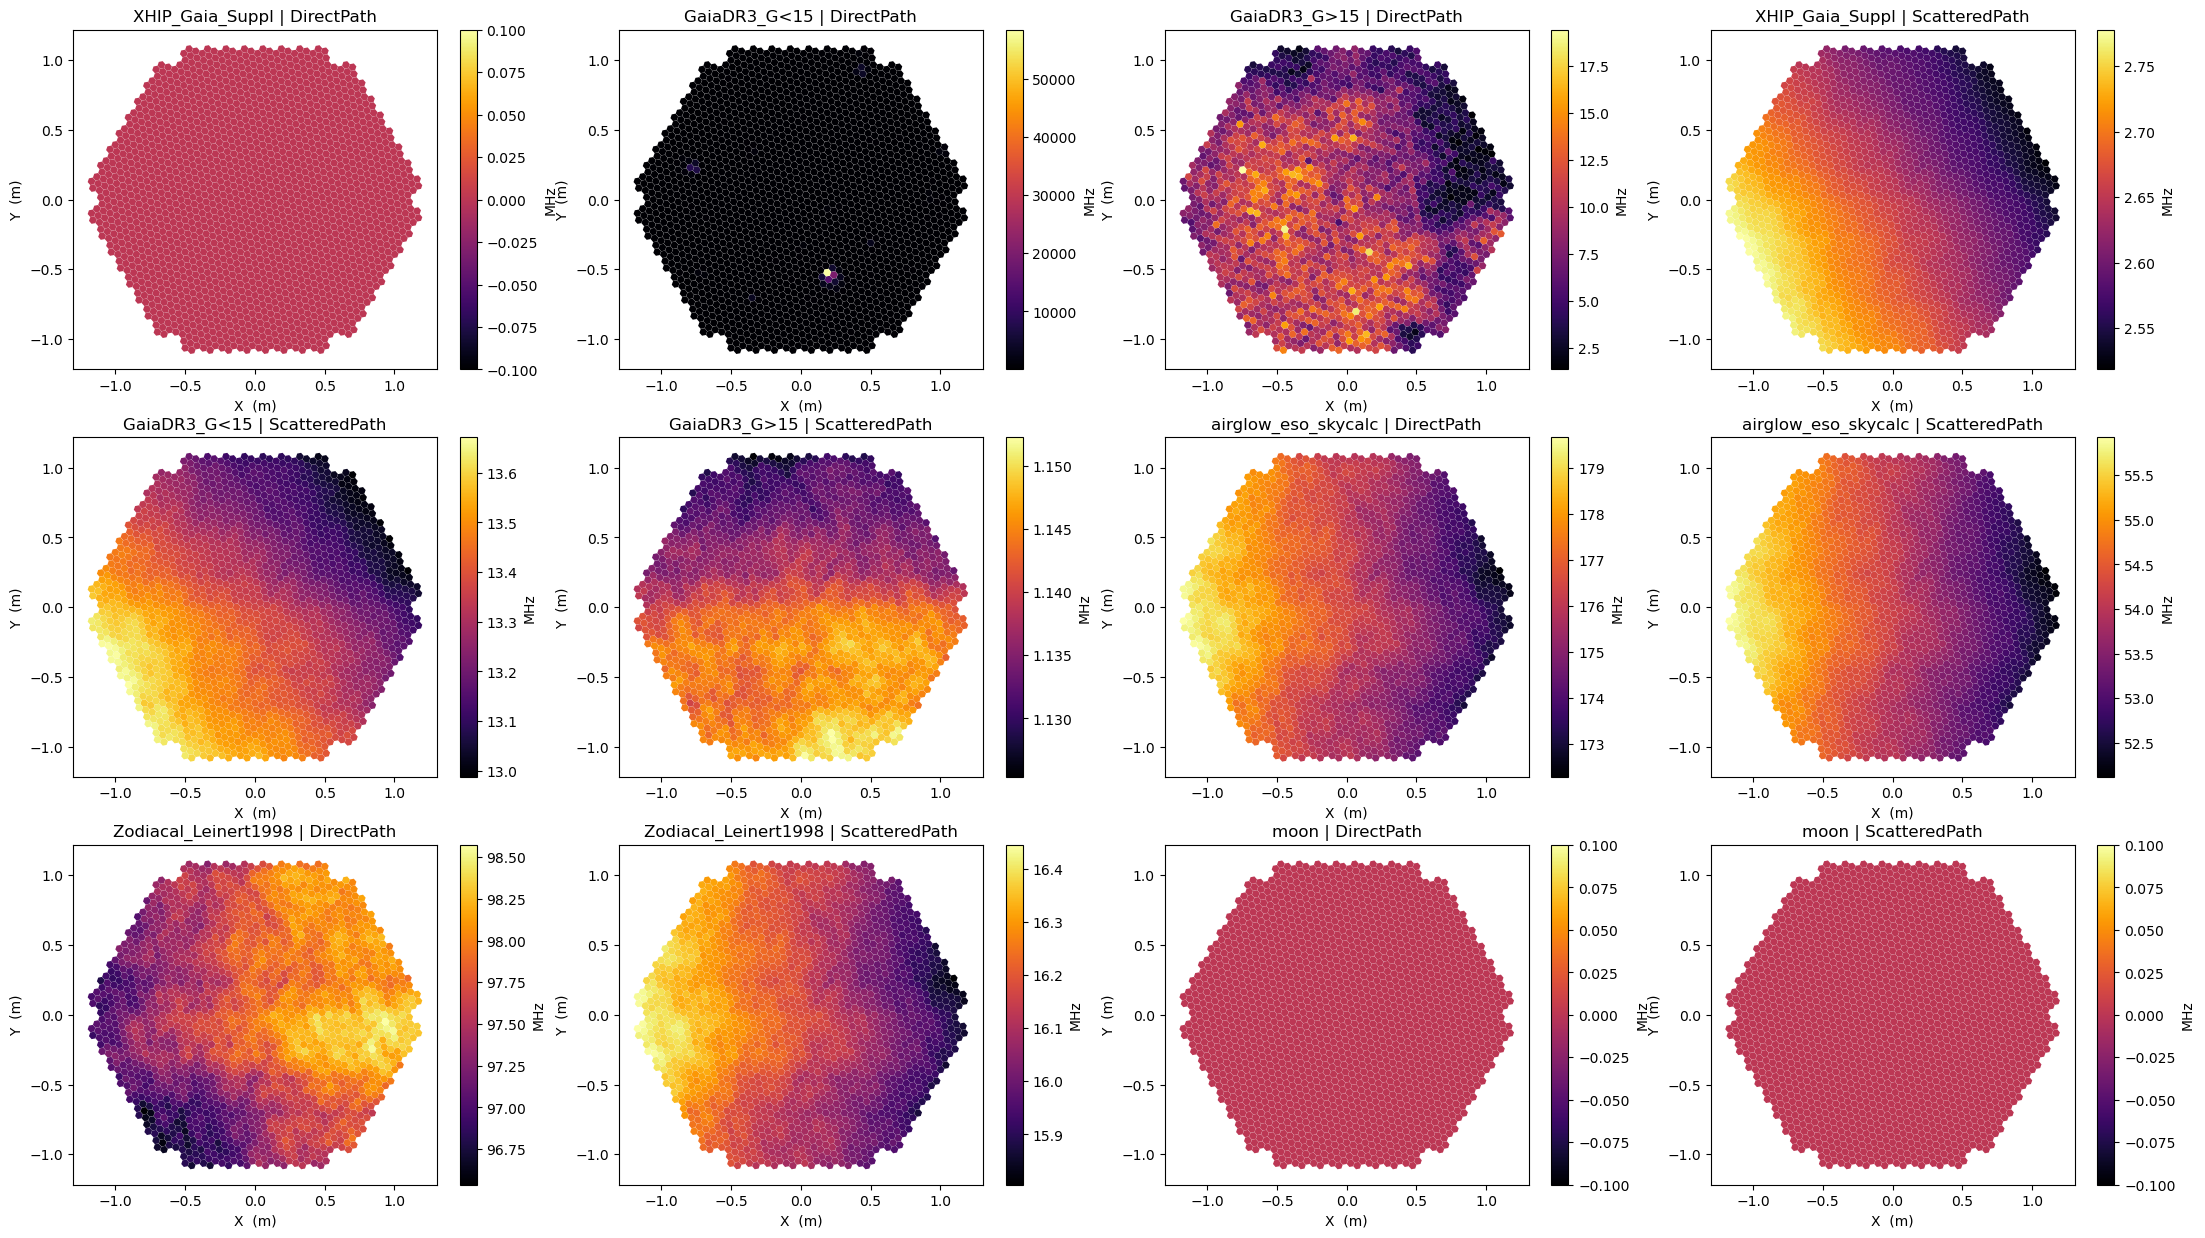

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=len(pred)//4, figsize=(27,5*(len(pred)//4)))

for i in range(len(pred)):
    disp = ctapipe_disp(cam,  pred[i].rates.to(u.MHz)[:,1], ax[i//4,i%4], label='MHz',
                        title=pred[i].source_name +" | " + pred[i].path_name, show_frame=False)